# Load libraries

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R 
library(tidyverse)
library(readxl)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Load data

The goal here is to determine the if certain environments are enriched for microcins. To do that,we need information about the assemblies so that we can figure out which environments they came from.


In [4]:
%%R
assemblySummary_SequencedGenomes <- read_excel("data/Ecoli_assemblySummary.xlsx", sheet="Sequenced-Genomes", skip=5) %>%
	separate("Sequence_Name",c("phylogroup")) %>%
	select(c("Genome_ID","phylogroup","Isolation source","Strain Category")) %>%
	rename("GEMBASE_NAME"="Genome_ID") %>%
	drop_na()
assemblySummary_ENAInformation <- read_excel("data/Ecoli_assemblySummary.xlsx", sheet="ENA-Information")
best_hits <- read_csv("data/Ecoli_pangenome_best_hits.csv")


R[write to console]: New names:
* `` -> ...8
* `` -> ...20
* `` -> ...28
* `` -> ...35



Rows: 7262 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): qseqid, sseqid, component, cinful_id, pephash, sample, contig, seq
dbl (13): pident, length, mismatch, gapopen, qstart, qend, sstart, send, eva...
lgl  (4): hmmerHit, verified, allStandardAA, signalMatch

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
%%R
best_hits_assemblyID <- best_hits %>%
	separate(cinful_id,c(NA, "ASSEMBLY_ACC_ID"), sep="/") %>%
	separate(ASSEMBLY_ACC_ID, c("ASSEMBLY_ACC"), sep = "[.]")

In [6]:
%%R 
assemblySummary_Annotated <- assemblySummary_ENAInformation %>%
	full_join(assemblySummary_SequencedGenomes) %>%
	drop_na()

Joining, by = "GEMBASE_NAME"


In [7]:
%%R
best_hits_assemblyID_Annotated <- best_hits_assemblyID %>%
	full_join(assemblySummary_Annotated) %>%
	filter(component == "microcins.verified") %>%
	select(ASSEMBLY_ACC,phylogroup,sseqid,verified, `Strain Category`)


Joining, by = "ASSEMBLY_ACC"


In [8]:
%%R

microcinAssemblyProportion <- length(best_hits_assemblyID_Annotated$ASSEMBLY_ACC) /length(assemblySummary_Annotated$ASSEMBLY_ACC)
microcinAssemblyProportion

[1] 0.3316993


In [9]:
%%R
strain_category_assemblies <- assemblySummary_Annotated %>%
	count(`Strain Category`, name="total_assemblies")
strain_category_assemblies

# A tibble: 9 × 2
  `Strain Category`      total_assemblies
  <chr>                             <int>
1 Alone                                 5
2 Bird_Faecal                         185
3 Human_Extra-intestinal              104
4 Human_Faecal                         75
5 Human_Intestinal                    172
6 Mammal_Faecal                       117
7 Poultry_Meat                        283
8 Soil                                  3
9 Water                               280


In [10]:
%%R -w 1500
microcin_strain_category <- best_hits_assemblyID_Annotated %>%
	count(`Strain Category`, name = "microcin") %>%
	add_row(`Strain Category`= "Soil", microcin = 0) %>%
	full_join(strain_category_assemblies) %>%
	mutate( relative_microcin = microcin / total_assemblies) %>%
	mutate(odds = relative_microcin/(microcinAssemblyProportion))%>%
	mutate(LOE = log10(odds))
microcin_strain_category

Joining, by = "Strain Category"
# A tibble: 9 × 6
  `Strain Category`   microcin total_assemblies relative_microc…  odds       LOE
  <chr>                  <dbl>            <int>            <dbl> <dbl>     <dbl>
1 Alone                      1                5            0.2   0.603   -0.220 
2 Bird_Faecal               50              185            0.270 0.815   -0.0889
3 Human_Extra-intest…       52              104            0.5   1.51     0.178 
4 Human_Faecal              22               75            0.293 0.884   -0.0534
5 Human_Intestinal          64              172            0.372 1.12     0.0499
6 Mammal_Faecal             47              117            0.402 1.21     0.0832
7 Poultry_Meat             122              283            0.431 1.30     0.114 
8 Water                     48              280            0.171 0.517   -0.287 
9 Soil                       0                3            0     0     -Inf     


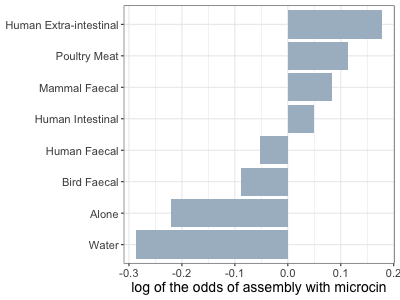

In [11]:
%%R -w 400 -h 300

microcin_strain_category %>%
	mutate(`Strain Category` = str_replace(`Strain Category`, "([_])", " ")) %>%
	filter(`Strain Category` != "Soil") %>%
	ggplot(aes(y = reorder(`Strain Category`,LOE), x = LOE)) +
		geom_bar(stat = "identity", 
		fill = "#aabbcaff"#"#427281"
		) +
		ylab(NULL) + 
		xlab("log of the odds of assembly with microcin") +
		theme_bw() +
		theme(text = element_text(size = 14))
# ggsave("microcin_strain_category.svg")

In [12]:
%%R -w 400 -h 300

microcin_strain_category %>%
	mutate(`Strain Category` = str_replace(`Strain Category`, "([_])", " ")) %>%
	filter(`Strain Category` != "Soil") %>%
	ggplot(aes(y = reorder(`Strain Category`,LOE), x = LOE)) +
		geom_bar(stat = "identity", 
		fill = "#aabbcaff"#"#427281"
		) +
		ylab(NULL) + 
		xlab("log of the odds of assembly with microcin") +
		theme_bw() +
		theme(text = element_text(size = 14))
ggsave("plots/03_microcin_strain_category.svg")

R[write to console]: Saving 5.56 x 4.17 in image



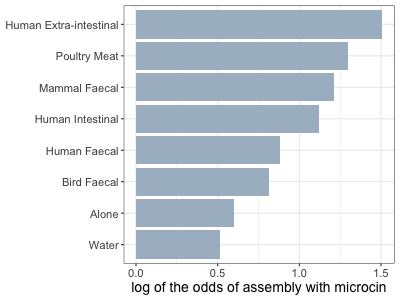

In [13]:
%%R -w 400 -h 300

microcin_strain_category %>%
	mutate(`Strain Category` = str_replace(`Strain Category`, "([_])", " ")) %>%
	filter(`Strain Category` != "Soil") %>%
	ggplot(aes(y = reorder(`Strain Category`,odds), x = odds)) +
		geom_bar(stat = "identity", 
		fill = "#aabbcaff"#"#427281"
		) +
		ylab(NULL) + 
		xlab("log of the odds of assembly with microcin") +
		theme_bw() +
		theme(text = element_text(size = 14))
# ggsave("microcin_strain_category.svg")